# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 5s 27ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 19.0157 - energy_loss: 0.2891 - force_loss: 0.9363 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9437 - energy_loss: 0.2261 - force_loss: 0.9359 - 536ms/epoch - 67ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9270 - energy_loss: 0.2157 - force_loss: 0.9356 - 536ms/epoch - 67ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.9032 - energy_loss: 0.2097 - force_loss: 0.9347 - 557ms/epoch - 70ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.8274 - energy_loss: 0.2098 - force_loss: 0.9309 - 529ms/epoch - 66ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.7257 - energy_loss: 0.4770 - force_loss: 0.9124 - 531ms/epoch - 66ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.5668 - energy_loss: 0.3896 - force_loss: 0.9089 - 539ms/epoch - 67ms/step
Epoch 8/1500
8/8 - 1s - loss: 18.2896 - energy_loss: 0.3048 - force_loss: 0.8992 - 529ms/epoch - 66ms/step
Epoch 9/1500
8/8 - 1s - loss: 17.5369 - energy_loss: 0.5290 - force_loss: 0.8504 - 542ms/epoch - 68ms/step
Epoch 10/1500
8/8 - 1s - loss: 17.1469 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.4033 - energy_loss: 0.8285 - force_loss: 0.2787 - 539ms/epoch - 67ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.1271 - energy_loss: 0.7892 - force_loss: 0.2669 - 549ms/epoch - 69ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.1557 - energy_loss: 0.7787 - force_loss: 0.2688 - 531ms/epoch - 66ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.1758 - energy_loss: 0.8110 - force_loss: 0.2682 - 538ms/epoch - 67ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.1984 - energy_loss: 0.8019 - force_loss: 0.2698 - 541ms/epoch - 68ms/step
Epoch 83/1500
8/8 - 1s - loss: 5.9882 - energy_loss: 0.7614 - force_loss: 0.2613 - 540ms/epoch - 68ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.0043 - energy_loss: 0.7624 - force_loss: 0.2621 - 537ms/epoch - 67ms/step
Epoch 85/1500
8/8 - 1s - loss: 5.9462 - energy_loss: 0.7265 - force_loss: 0.2610 - 531ms/epoch - 66ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.0452 - energy_loss: 0.7800 - force_loss: 0.2633 - 525ms/epoch - 66ms/step
Epoch 87/1500
8/8 - 1s - loss: 5.8538

8/8 - 1s - loss: 4.3136 - energy_loss: 0.5858 - force_loss: 0.1864 - 526ms/epoch - 66ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.4922 - energy_loss: 0.5884 - force_loss: 0.1952 - 525ms/epoch - 66ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.3522 - energy_loss: 0.5249 - force_loss: 0.1914 - 528ms/epoch - 66ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.1844 - energy_loss: 0.5483 - force_loss: 0.1818 - 546ms/epoch - 68ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.5140 - energy_loss: 0.8985 - force_loss: 0.1808 - 539ms/epoch - 67ms/step
Epoch 159/1500
8/8 - 1s - loss: 3.8116 - energy_loss: 0.2713 - force_loss: 0.1770 - 529ms/epoch - 66ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.2882 - energy_loss: 0.7260 - force_loss: 0.1781 - 524ms/epoch - 66ms/step
Epoch 161/1500
8/8 - 1s - loss: 3.8234 - energy_loss: 0.2773 - force_loss: 0.1773 - 525ms/epoch - 66ms/step
Epoch 162/1500
8/8 - 1s - loss: 3.9159 - energy_loss: 0.4911 - force_loss: 0.1712 - 524ms/epoch - 66ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.0776 - en

Epoch 230/1500
8/8 - 1s - loss: 3.6646 - energy_loss: 0.4915 - force_loss: 0.1587 - 645ms/epoch - 81ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.9752 - energy_loss: 0.3677 - force_loss: 0.1804 - 616ms/epoch - 77ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.5505 - energy_loss: 0.5179 - force_loss: 0.1516 - 656ms/epoch - 82ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.5645 - energy_loss: 0.5153 - force_loss: 0.1525 - 645ms/epoch - 81ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.8133 - energy_loss: 0.4930 - force_loss: 0.1660 - 682ms/epoch - 85ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.9881 - energy_loss: 0.6016 - force_loss: 0.1693 - 672ms/epoch - 84ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.5959 - energy_loss: 0.5029 - force_loss: 0.1547 - 1s/epoch - 130ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.3912 - energy_loss: 0.4926 - force_loss: 0.1449 - 1000ms/epoch - 125ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.4197 - energy_loss: 0.5252 - force_loss: 0.1447 - 672ms/epoch - 84ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.0285 - energy_loss: 0.4771 - force_loss: 0.1276 - 616ms/epoch - 77ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.0781 - energy_loss: 0.4404 - force_loss: 0.1319 - 590ms/epoch - 74ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.0796 - energy_loss: 0.4299 - force_loss: 0.1325 - 596ms/epoch - 74ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.1949 - energy_loss: 0.4851 - force_loss: 0.1355 - 598ms/epoch - 75ms/step
Epoch 310/1500
8/8 - 1s - loss: 2.8509 - energy_loss: 0.1990 - force_loss: 0.1326 - 597ms/epoch - 75ms/step
Epoch 311/1500
8/8 - 1s - loss: 2.8848 - energy_loss: 0.2239 - force_loss: 0.1330 - 600ms/epoch - 75ms/step
Epoch 312/1500
8/8 - 1s - loss: 2.7977 - energy_loss: 0.2369 - force_loss: 0.1280 - 608ms/epoch - 76ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.0245 - energy_loss: 0.5162 - force_loss: 0.1254 - 614ms/epoch - 77ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.4153 - energy_loss: 0.8714 - force_loss: 0.1272 - 649ms/epoch - 81ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 2.8664 - energy_loss: 0.3565 - force_loss: 0.1255 - 567ms/epoch - 71ms/step
Epoch 383/1500
8/8 - 1s - loss: 2.8862 - energy_loss: 0.3487 - force_loss: 0.1269 - 560ms/epoch - 70ms/step
Epoch 384/1500
8/8 - 1s - loss: 3.0246 - energy_loss: 0.6317 - force_loss: 0.1196 - 548ms/epoch - 69ms/step
Epoch 385/1500
8/8 - 1s - loss: 3.2137 - energy_loss: 0.6694 - force_loss: 0.1272 - 566ms/epoch - 71ms/step
Epoch 386/1500
8/8 - 1s - loss: 3.2959 - energy_loss: 0.6857 - force_loss: 0.1305 - 556ms/epoch - 69ms/step
Epoch 387/1500
8/8 - 1s - loss: 3.2251 - energy_loss: 0.6694 - force_loss: 0.1278 - 564ms/epoch - 70ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.9512 - energy_loss: 0.3848 - force_loss: 0.1283 - 558ms/epoch - 70ms/step
Epoch 389/1500
8/8 - 1s - loss: 3.0996 - energy_loss: 0.4199 - force_loss: 0.1340 - 575ms/epoch - 72ms/step
Epoch 390/1500
8/8 - 1s - loss: 3.3139 - energy_loss: 0.4149 - force_loss: 0.1449 - 562ms/epoch - 70ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.6045 - energy_loss: 0.4494 - force_loss: 0.1078 - 567ms/epoch - 71ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.5159 - energy_loss: 0.3641 - force_loss: 0.1076 - 557ms/epoch - 70ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.5959 - energy_loss: 0.4699 - force_loss: 0.1063 - 561ms/epoch - 70ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.9036 - energy_loss: 0.6814 - force_loss: 0.1111 - 573ms/epoch - 72ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.5765 - energy_loss: 0.3580 - force_loss: 0.1109 - 569ms/epoch - 71ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.9292 - energy_loss: 0.7398 - force_loss: 0.1095 - 559ms/epoch - 70ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.6804 - energy_loss: 0.4649 - force_loss: 0.1108 - 553ms/epoch - 69ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.5103 - energy_loss: 0.3313 - force_loss: 0.1090 - 570ms/epoch - 71ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.5240 - energy_loss: 0.3711 - force_loss: 0.1076 - 555ms/epoch - 69ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 3.0942 - energy_loss: 0.7399 - force_loss: 0.1177 - 556ms/epoch - 69ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.9213 - energy_loss: 0.6379 - force_loss: 0.1142 - 564ms/epoch - 71ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.7208 - energy_loss: 0.3813 - force_loss: 0.1170 - 557ms/epoch - 70ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.7989 - energy_loss: 0.4024 - force_loss: 0.1198 - 556ms/epoch - 69ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.9654 - energy_loss: 0.4731 - force_loss: 0.1246 - 539ms/epoch - 67ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.7045 - energy_loss: 0.3785 - force_loss: 0.1163 - 542ms/epoch - 68ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.6388 - energy_loss: 0.4658 - force_loss: 0.1086 - 559ms/epoch - 70ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.4005 - energy_loss: 0.3267 - force_loss: 0.1037 - 555ms/epoch - 69ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.3828 - energy_loss: 0.3936 - force_loss: 0.0995 - 567ms/epoch - 71ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.5819 - energy_loss: 0.5077 - force_loss: 0.1037 - 579ms/epoch - 72ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.4582 - energy_loss: 0.3847 - force_loss: 0.1037 - 567ms/epoch - 71ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.3830 - energy_loss: 0.4283 - force_loss: 0.0977 - 567ms/epoch - 71ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.3828 - energy_loss: 0.3119 - force_loss: 0.1035 - 567ms/epoch - 71ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.5097 - energy_loss: 0.3729 - force_loss: 0.1068 - 567ms/epoch - 71ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.4183 - energy_loss: 0.3626 - force_loss: 0.1028 - 567ms/epoch - 71ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.4055 - energy_loss: 0.3309 - force_loss: 0.1037 - 563ms/epoch - 70ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.5134 - energy_loss: 0.3971 - force_loss: 0.1058 - 576ms/epoch - 72ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.3995 - energy_loss: 0.3156 - force_loss: 0.1042 - 560ms/epoch - 70ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.5021 - energy_loss: 0.3000 - force_loss: 0.1101 - 553ms/epoch - 69ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.2295 - energy_loss: 0.2550 - force_loss: 0.0987 - 557ms/epoch - 70ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.3548 - energy_loss: 0.2904 - force_loss: 0.1032 - 559ms/epoch - 70ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.1998 - energy_loss: 0.3090 - force_loss: 0.0945 - 597ms/epoch - 75ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.2592 - energy_loss: 0.3327 - force_loss: 0.0963 - 557ms/epoch - 70ms/step
Epoch 691/1500
8/8 - 1s - loss: 1.9774 - energy_loss: 0.1741 - force_loss: 0.0902 - 552ms/epoch - 69ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.1767 - energy_loss: 0.3916 - force_loss: 0.0893 - 562ms/epoch - 70ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.5197 - energy_loss: 0.6432 - force_loss: 0.0938 - 558ms/epoch - 70ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.5352 - energy_loss: 0.5746 - force_loss: 0.0980 - 550ms/epoch - 69ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.1770 - energy_loss: 0.3533 - force_loss: 0.0912 - 553ms/epoch - 69ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.2238 - energy_loss: 0.3786 - force_loss: 0.0923 - 547ms/epoch - 68ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.1532 - energy_loss: 0.3628 - force_loss: 0.0895 - 547ms/epoch - 68ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.1726 - energy_loss: 0.3542 - force_loss: 0.0909 - 544ms/epoch - 68ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.1312 - energy_loss: 0.3454 - force_loss: 0.0893 - 552ms/epoch - 69ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.1446 - energy_loss: 0.3468 - force_loss: 0.0899 - 555ms/epoch - 69ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.1379 - energy_loss: 0.3569 - force_loss: 0.0891 - 549ms/epoch - 69ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.1962 - energy_loss: 0.3541 - force_loss: 0.0921 - 559ms/epoch - 70ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.1562 - energy_loss: 0.3307 - force_loss: 0.0913 - 554ms/epoch - 69ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.1352 - energy_loss: 0.3255 - force_loss: 0.0905 - 539ms/epoch - 67ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.1568 - energy_loss: 0.3603 - force_loss: 0.0898 - 555ms/epoch - 69ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.0927 - energy_loss: 0.3046 - force_loss: 0.0894 - 547ms/epoch - 68ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.0165 - energy_loss: 0.3215 - force_loss: 0.0847 - 569ms/epoch - 71ms/step
Epoch 842/1500
8/8 - 1s - loss: 1.9910 - energy_loss: 0.3159 - force_loss: 0.0838 - 555ms/epoch - 69ms/step
Epoch 843/1500
8/8 - 1s - loss: 1.9713 - energy_loss: 0.3131 - force_loss: 0.0829 - 563ms/epoch - 70ms/step
Epoch 844/1500
8/8 - 1s - loss: 1.9651 - energy_loss: 0.3353 - force_loss: 0.0815 - 538ms/epoch - 67ms/step
Epoch 845/1500
8/8 - 1s - loss: 1.9788 - energy_loss: 0.3018 - force_loss: 0.0839 - 541ms/epoch - 68ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.0865 - energy_loss: 0.3215 - force_loss: 0.0882 - 542ms/epoch - 68ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 1.9669 - energy_loss: 0.3250 - force_loss: 0.0821 - 558ms/epoch - 70ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.0015 - energy_loss: 0.2744 - force_loss: 0.0864 - 564ms/epoch - 70ms/step
Epoch 916/1500
8/8 - 1s - loss: 2.0425 - energy_loss: 0.3054 - force_loss: 0.0869 - 554ms/epoch - 69ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.0942 - energy_loss: 0.3916 - force_loss: 0.0851 - 559ms/epoch - 70ms/step
Epoch 918/1500
8/8 - 1s - loss: 1.9704 - energy_loss: 0.2654 - force_loss: 0.0852 - 560ms/epoch - 70ms/step
Epoch 919/1500
8/8 - 1s - loss: 1.8390 - energy_loss: 0.1445 - force_loss: 0.0847 - 554ms/epoch - 69ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.1687 - energy_loss: 0.3125 - force_loss: 0.0928 - 560ms/epoch - 70ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.1074 - energy_loss: 0.2939 - force_loss: 0.0907 - 553ms/epoch - 69ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.0782 - energy_loss: 0.3186 - force_loss: 0.0880 - 554ms/epoch - 69ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.1393 - energy_loss: 0.5076 - force_loss: 0.0816 - 557ms/epoch - 70ms/step
Epoch 991/1500
8/8 - 1s - loss: 2.1353 - energy_loss: 0.4899 - force_loss: 0.0823 - 554ms/epoch - 69ms/step
Epoch 992/1500
8/8 - 1s - loss: 2.1591 - energy_loss: 0.5491 - force_loss: 0.0805 - 553ms/epoch - 69ms/step
Epoch 993/1500
8/8 - 1s - loss: 2.0443 - energy_loss: 0.4303 - force_loss: 0.0807 - 560ms/epoch - 70ms/step
Epoch 994/1500
8/8 - 1s - loss: 2.0972 - energy_loss: 0.4083 - force_loss: 0.0844 - 557ms/epoch - 70ms/step
Epoch 995/1500
8/8 - 1s - loss: 2.0601 - energy_loss: 0.3029 - force_loss: 0.0879 - 569ms/epoch - 71ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.8749 - energy_loss: 0.1671 - force_loss: 0.0854 - 553ms/epoch - 69ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.7604 - energy_loss: 0.1912 - force_loss: 0.0785 - 551ms/epoch - 69ms/step
Epoch 998/1500
8/8 - 1s - loss: 1.9462 - energy_loss: 0.2760 - force_loss: 0.0835 - 554ms/epoch - 69ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.9874 - energy_loss: 0.3993 - force_loss: 0.0794 - 560ms/epoch - 70ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.9601 - energy_loss: 0.3057 - force_loss: 0.0827 - 560ms/epoch - 70ms/step
Epoch 1068/1500
8/8 - 1s - loss: 2.1923 - energy_loss: 0.3713 - force_loss: 0.0910 - 567ms/epoch - 71ms/step
Epoch 1069/1500
8/8 - 1s - loss: 1.8667 - energy_loss: 0.2082 - force_loss: 0.0829 - 538ms/epoch - 67ms/step
Epoch 1070/1500
8/8 - 1s - loss: 1.7149 - energy_loss: 0.1616 - force_loss: 0.0777 - 560ms/epoch - 70ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.7386 - energy_loss: 0.2162 - force_loss: 0.0761 - 566ms/epoch - 71ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.8784 - energy_loss: 0.3003 - force_loss: 0.0789 - 574ms/epoch - 72ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.8480 - energy_loss: 0.2079 - force_loss: 0.0820 - 555ms/epoch - 69ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.9288 - energy_loss: 0.3507 - force_loss: 0.0789 - 561ms/epoch - 70ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.7018 - energy_loss: 0.2726 - force_loss: 0.0715 - 560ms/epoch - 70ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.5811 - energy_loss: 0.1199 - force_loss: 0.0731 - 566ms/epoch - 71ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.5744 - energy_loss: 0.1356 - force_loss: 0.0719 - 565ms/epoch - 71ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.6880 - energy_loss: 0.2924 - force_loss: 0.0698 - 567ms/epoch - 71ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.9976 - energy_loss: 0.5658 - force_loss: 0.0716 - 584ms/epoch - 73ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.8164 - energy_loss: 0.4116 - force_loss: 0.0702 - 571ms/epoch - 71ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.9851 - energy_loss: 0.5527 - force_loss: 0.0716 - 543ms/epoch - 68ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.8402 - energy_loss: 0.4453 - force_loss: 0.0697 - 549ms/epoch - 69ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.8159 - energy_loss: 0.3628 - force_loss: 0.0727 - 562ms/epoch - 70ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 2.3773 - energy_loss: 0.8199 - force_loss: 0.0779 - 564ms/epoch - 70ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8416 - energy_loss: 0.2314 - force_loss: 0.0805 - 554ms/epoch - 69ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.9747 - energy_loss: 0.3630 - force_loss: 0.0806 - 559ms/epoch - 70ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.8747 - energy_loss: 0.3377 - force_loss: 0.0768 - 559ms/epoch - 70ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.8063 - energy_loss: 0.3022 - force_loss: 0.0752 - 557ms/epoch - 70ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.9301 - energy_loss: 0.3068 - force_loss: 0.0812 - 566ms/epoch - 71ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.8506 - energy_loss: 0.3085 - force_loss: 0.0771 - 559ms/epoch - 70ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.8405 - energy_loss: 0.3104 - force_loss: 0.0765 - 564ms/epoch - 70ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.8071 - energy_loss: 0.3057 - force_loss: 0.0751 - 554ms/epoch - 69ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.7162 - energy_loss: 0.3035 - force_loss: 0.0706 - 556ms/epoch - 69ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.6103 - energy_loss: 0.2405 - force_loss: 0.0685 - 569ms/epoch - 71ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.6974 - energy_loss: 0.2945 - force_loss: 0.0701 - 559ms/epoch - 70ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.8440 - energy_loss: 0.2691 - force_loss: 0.0787 - 599ms/epoch - 75ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.8402 - energy_loss: 0.3273 - force_loss: 0.0756 - 624ms/epoch - 78ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.6022 - energy_loss: 0.1266 - force_loss: 0.0738 - 572ms/epoch - 71ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.5321 - energy_loss: 0.1311 - force_loss: 0.0701 - 559ms/epoch - 70ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.4737 - energy_loss: 0.1317 - force_loss: 0.0671 - 548ms/epoch - 69ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.4952 - energy_loss: 0.1228 - force_loss: 0.0686 - 552ms/epoch - 69ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.7273 - energy_loss: 0.2554 - force_loss: 0.0736 - 538ms/epoch - 67ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.9089 - energy_loss: 0.5245 - force_loss: 0.0692 - 566ms/epoch - 71ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.6710 - energy_loss: 0.2598 - force_loss: 0.0706 - 558ms/epoch - 70ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7991 - energy_loss: 0.4240 - force_loss: 0.0688 - 546ms/epoch - 68ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.7436 - energy_loss: 0.2981 - force_loss: 0.0723 - 552ms/epoch - 69ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.5008 - energy_loss: 0.1440 - force_loss: 0.0678 - 560ms/epoch - 70ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.6058 - energy_loss: 0.2713 - force_loss: 0.0667 - 544ms/epoch - 68ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.6649 - energy_loss: 0.3012 - force_loss: 0.0682 - 554ms/epoch - 69ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6703 - energy_loss: 0.2943 - force_loss: 0.0688 - 559ms/epoch - 70ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6174 - energy_loss: 0.2711 - force_loss: 0.0673 - 558ms/epoch - 70ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.5928 - energy_loss: 0.2745 - force_loss: 0.0659 - 577ms/epoch - 72ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.5748 - energy_loss: 0.2835 - force_loss: 0.0646 - 628ms/epoch - 78ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.5540 - energy_loss: 0.2684 - force_loss: 0.0643 - 668ms/epoch - 83ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.5987 - energy_loss: 0.2625 - force_loss: 0.0668 - 715ms/epoch - 89ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.6644 - energy_loss: 0.2790 - force_loss: 0.0693 - 598ms/epoch - 75ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.6502 - energy_loss: 0.2296 - force_loss: 0.0710 - 549ms/epoch - 69ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.4385 - energy_loss: 0.1222 - force_loss: 0.0658 - 558ms/epoch - 70ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.3864 - energy_loss: 0.1262 - force_loss: 0.0630 - 545ms/epoch - 68ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

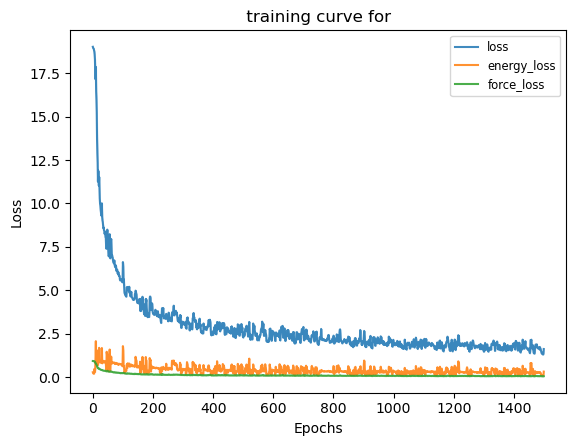

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.moldyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3    
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array([-17469.72659472]),
 'forces': array([[-2.7022052 ,  2.6067295 , -0.80132294],
        [-0.94237494, -0.8543645 ,  2.0503235 ],
        [ 3.1250453 , -2.2155688 , -0.18858123],
        [-0.34163842,  1.7312989 , -0.19887492],
        [ 0.10409817,  1.8229537 ,  0.8098041 ],
        [-0.61970544,  0.26135075, -0.05738294],
        [ 0.17978151,  0.84497315, -2.200481  ],
        [-0.37210774, -1.2363522 , -0.01422253],
        [ 0.50601923,  3.8382761 ,  1.9685562 ],
        [-0.70432127,  2.0838108 ,  0.7489469 ],
        [ 1.2494129 , -1.1803133 ,  0.48152077],
        [ 0.4650333 , -3.8159986 , -1.8901086 ],
        [ 1.8119826 , -1.0686251 , -0.61991173],
        [-0.32360613, -0.64180607,  0.49936235],
        [ 1.2304082 , -1.90963   ,  1.3731015 ],
        [ 0.08956418,  0.3307327 , -0.8767537 ],
        [-1.0983629 ,  0.36785436, -0.16409475],
        [-0.4309523 ,  0.4623685 , -0.26846457],
        [-0.2850051 , -1.0888858 , -0.7115133 ],
        [-0.44173074, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.moldyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array(-17469.72659537), 'forces': array([[-2.7022033 ,  2.6067293 , -0.80132353],
       [-0.9423758 , -0.85436547,  2.050325  ],
       [ 3.1250453 , -2.2155683 , -0.18858099],
       [-0.3416388 ,  1.7312986 , -0.19887462],
       [ 0.10409676,  1.8229539 ,  0.8098038 ],
       [-0.6197065 ,  0.2613517 , -0.05738401],
       [ 0.17978175,  0.8449728 , -2.200481  ],
       [-0.37210813, -1.2363514 , -0.01422186],
       [ 0.50601923,  3.838275  ,  1.9685557 ],
       [-0.70432115,  2.08381   ,  0.7489471 ],
       [ 1.2494129 , -1.1803129 ,  0.48152053],
       [ 0.46503344, -3.8159983 , -1.8901085 ],
       [ 1.8119828 , -1.0686252 , -0.6199119 ],
       [-0.32360592, -0.6418058 ,  0.49936166],
       [ 1.2304082 , -1.9096301 ,  1.3731012 ],
       [ 0.089564  ,  0.33073282, -0.8767536 ],
       [-1.0983624 ,  0.36785406, -0.16409487],
       [-0.43095213,  0.46236846, -0.26846433],
       [-0.2850047 , -1.0888855 , -0.7115132 ],
       [-0.4417302 ,  0.32621053, -0.536351

In [28]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.904eV  Ekin = 0.056eV (T=434K)  Etot = -831.848eV
Energy per atom: Epot = -831.907eV  Ekin = 0.060eV (T=461K)  Etot = -831.847eV
Energy per atom: Epot = -831.906eV  Ekin = 0.056eV (T=434K)  Etot = -831.850eV
Energy per atom: Epot = -831.889eV  Ekin = 0.041eV (T=315K)  Etot = -831.848eV
Energy per atom: Epot = -831.903eV  Ekin = 0.056eV (T=434K)  Etot = -831.847eV
Energy per atom: Epot = -831.901eV  Ekin = 0.050eV (T=386K)  Etot = -831.851eV
Energy per atom: Epot = -831.897eV  Ekin = 0.049eV (T=383K)  Etot = -831.848eV
Energy per atom: Epot = -831.910eV  Ekin = 0.060eV (T=462K)  Etot = -831.851eV
Energy per atom: Epot = -831.913eV  Ekin = 0.063eV (T=484K)  Etot = -831.850eV
Energy per atom: Epot = -831.899eV  Ekin = 0.049eV (T=375K)  Etot = -831.851eV
Energy per atom: Epot = -831.913eV  Ekin = 0.062eV (T=480K)  Etot = -831.851eV
Energy per atom: Epot = -831.907eV  Ekin = 0.059eV (T=453K)  Etot = -831.849eV
Energy per atom: Epot = -831.895eV  Ekin = 0.048eV (

In [27]:
calc.model_predictor._last_input

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 1.41154948, -1.35876124, -0.59289319],
       [ 1.01746625,  1.40466272, -1.18291996],
       [ 2.2874342 , -0.60448698, -1.42749847],
       [ 2.05831057,  0.78139383, -1.77841985],
       [-3.2823002 ,  1.99258642,  0.14351398],
       [ 0.39369041, -0.64559213,  0.10395301],
       [ 0.19963051,  0.74484568, -0.20733748],
       [-1.27372517, -0.88202544,  1.84803574],
       [-2.4411968 , -0.13061834, -0.75918933],
       [-0.15070329, -2.67337078,  1.12337858],
       [-0.42583307, -1.34940567,  1.15149102],
       [-2.25902748,  0.97600354, -0.26579067],
       [-0.98155017,  1.33404595,  0.20832231],
       [-0.64113775, -3.26296171,  1.78870687],
       [ 1.62993753, -2.36690054, -0.39404987],
       [ 0.76967765,  2.42825418, -1.61718564],
       [ 3.1947357 , -1.02023382, -1.96268701],
       [ 2.71419868,  1.38437209, -2.46847256],
       [-3.65421

In [29]:
dyn_model._test_timing(conv(atoms))

0.05703125